In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

data = pd.read_csv("sales_train.csv")
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')
ori_data=data
data = data.groupby('date').sum()['item_cnt_day']
ori_data=ori_data.groupby('date').sum()['item_cnt_day']

In [2]:
#TEST stationarity with adfuller test and draw rolling average picture
def draw_rolling_average(data):
    data_mean=pd.rolling_mean(data,window=30)
    data_std=pd.rolling_std(data,window=30)
    plt.plot(data,label='Original')
    plt.plot(data_mean, label='Rolling Mean')
    plt.plot(data_std, label = 'Rolling Std')
    plt.legend()
    plt.show()
def DF_test(data): #adfuller test
    result = adfuller(data,autolag='AIC')
    print('Test Statistic:',result[0])
    print('p-value:',result[1])
    print('Lags Used:',result[2])
    print('Observations Used:',result[3])
    for key,value in result[4].items():
        print('Critical Value (%s)'%key, value)

In [3]:
#find the best p q
def test_p_q(data):
    pmax = int(len(data_log)/100)# the max p , q will no more than 100
    qmax = int(len(data_log)/100)
    bic_matrix = []
    for p in range(pmax+1):
        tmp = []
        for q in range(qmax+1):
            try:
                tmp.append(ARIMA(data_log, (p,1,q)).fit().bic)
            except:
                tmp.append(None)
                bic_matrix.append(tmp)
                bic_matrix = pd.DataFrame(bic_matrix)
                p,q = bic_matrix.stack().idxmin()#find the minimum BIC index
    print(u'Smallest BIC P Q is：%s、%s' %(p,q))

In [4]:
# draw grap
def Draw_pre(newres):
    plt.figure(figsize=(40,10))
    plt.plot(ori_data,color='green',label='original')
    plt.plot(newres,color='black',label='predict')
    plt.legend()
    plt.show()

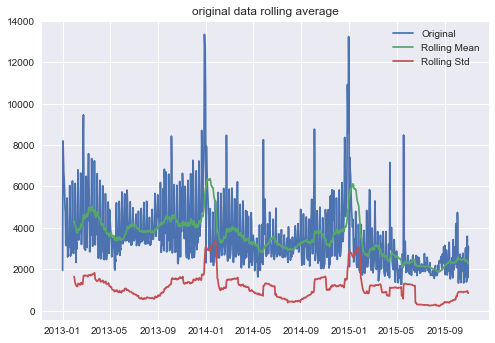

Test Statistic: -4.045604237566621
p-value: 0.001189666158171624
Lags Used: 21
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


In [5]:
# draw test error

def draw_test(data,predict):
    plt.plot(data['2015-10-01':'2015-10-30'],label='true')
    ownnewres=predict
    ownnewres = pd.DataFrame(ownnewres)
    ownnewres.index=pd.date_range('2015-10-01','2015-10-30')
    plt.plot(ownnewres, label='predict')
    plt.legend()
    plt.show()
plt.title("original data rolling average")
draw_rolling_average(data)
DF_test(data)

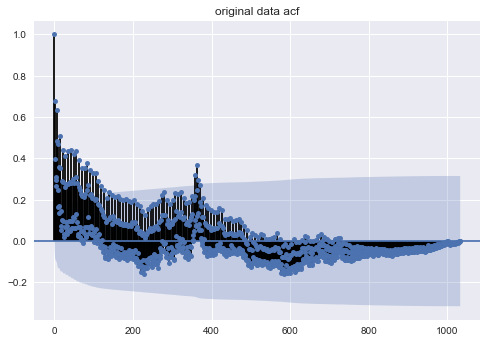

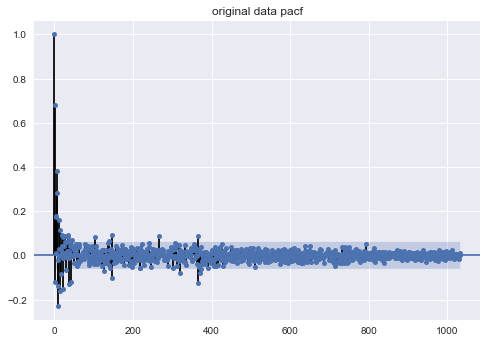

In [6]:
#plot ACF and PACF
plot_acf(data)
plt.title("original data acf")
plt.show()

plot_pacf(data)
plt.title("original data pacf")
plt.show()

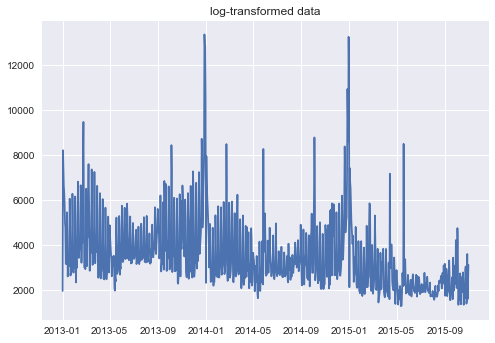

In [7]:
#log-transform
data_log=np.log(data)
plt.plot(data)
plt.title("log-transformed data")
plt.show()

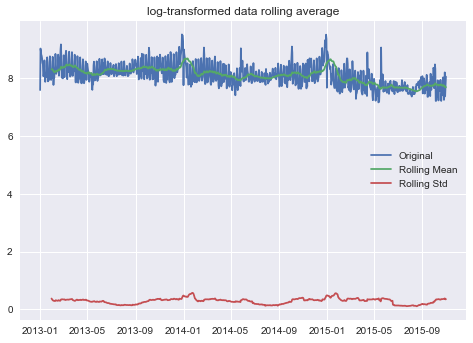

Test Statistic: -3.1307465959180583
p-value: 0.024359904888644573
Lags Used: 21
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


In [8]:
plt.title("log-transformed data rolling average")
draw_rolling_average(data_log)
DF_test(data_log)

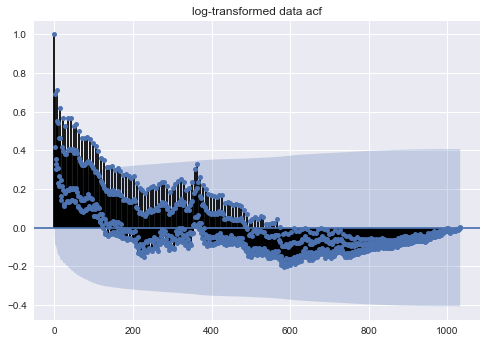

In [9]:
plot_acf(data_log)
plt.title("log-transformed data acf")
plt.show()

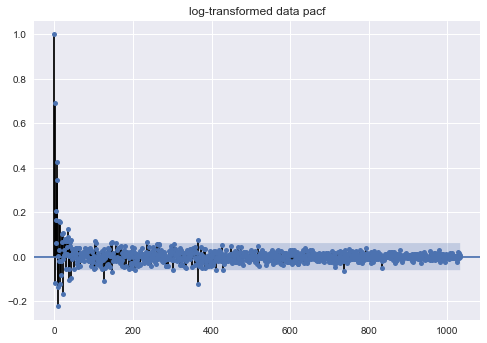

In [10]:
plot_pacf(data_log)
plt.title("log-transformed data pacf")
plt.show()

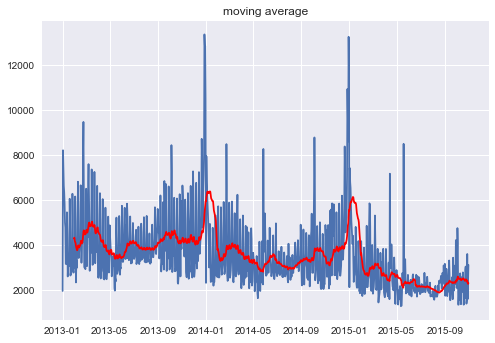

In [11]:
#moving average
moving_average = pd.rolling_mean(data,30)# moving average window sie = 30
plt.plot(data)
plt.plot(moving_average, color='red')
plt.title("moving average")
plt.show()

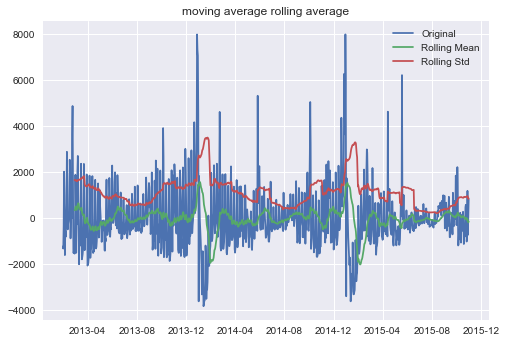

Test Statistic: -8.625276339599173
p-value: 5.953592152769708e-14
Lags Used: 22
Observations Used: 982
Critical Value (1%) -3.4370266558635914
Critical Value (5%) -2.864487711945291
Critical Value (10%) -2.5683395116993872


In [12]:
avg_diff = data - moving_average
avg_diff.dropna(inplace=True)
plt.title("moving average rolling average")
draw_rolling_average(avg_diff)
DF_test(avg_diff)

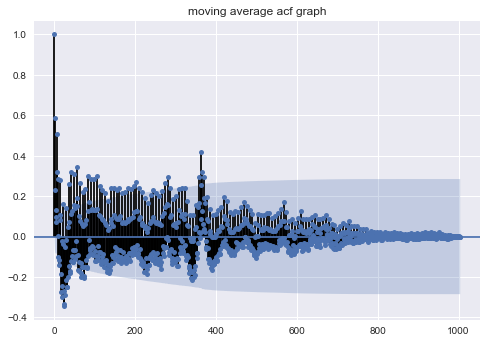

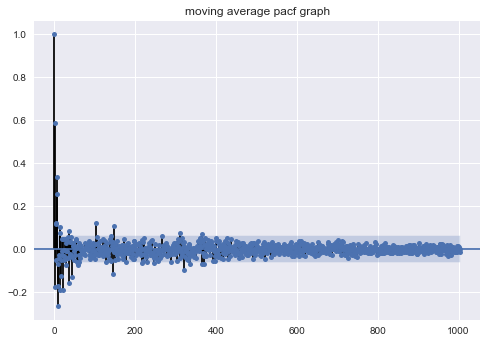

In [13]:
plot_acf(avg_diff)
plt.title("moving average acf graph")
plt.show()

plot_pacf(avg_diff)
plt.title("moving average pacf graph")
plt.show()

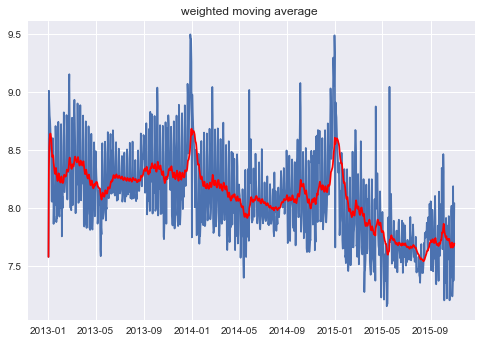

In [14]:
#EWMA
avg_weight = pd.ewma(data_log, halflife=12)
plt.plot(data_log)
plt.plot(avg_weight, color='red')
plt.title("weighted moving average ")
plt.show()

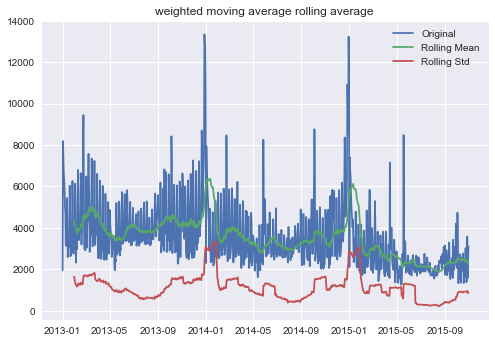

Test Statistic: -4.0462801396919605
p-value: 0.0011866501042521124
Lags Used: 21
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


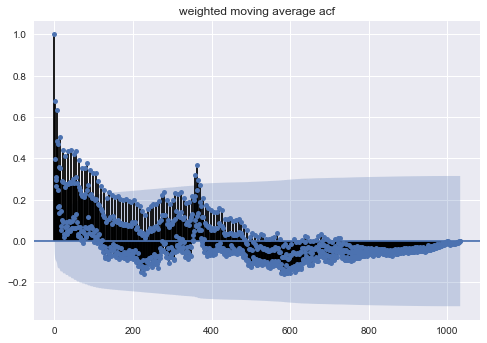

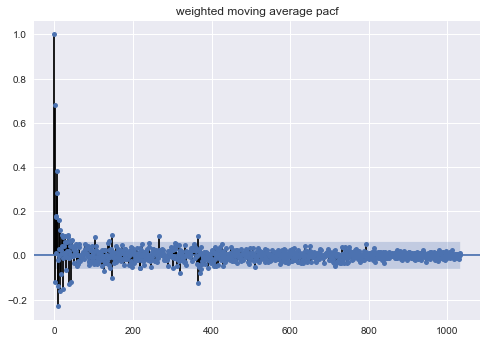

In [15]:
ewma_diff = data - avg_weight
plt.title("weighted moving average rolling average ")
draw_rolling_average(ewma_diff)
DF_test(ewma_diff)
plot_acf(ewma_diff)
plt.title("weighted moving average acf")
plt.show()
plot_pacf(ewma_diff)
plt.title("weighted moving average pacf")
plt.show()

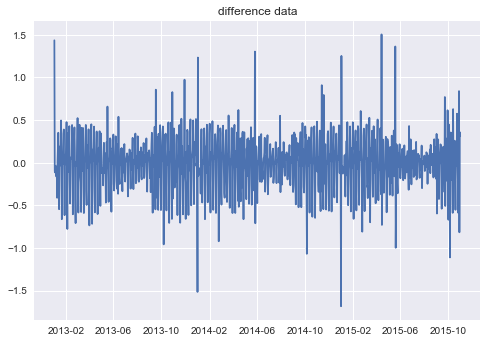

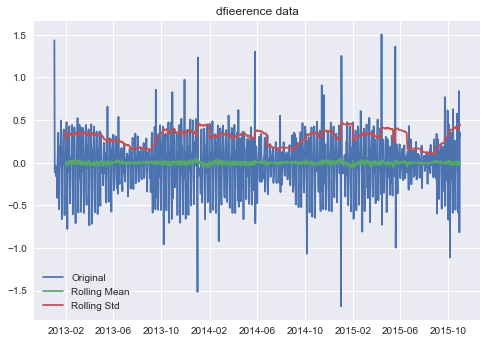

Test Statistic: -8.875396418925908
p-value: 1.3623351374725232e-14
Lags Used: 20
Observations Used: 1012
Critical Value (1%) -3.436828225807217
Critical Value (5%) -2.8644002004847144
Critical Value (10%) -2.568292900881126


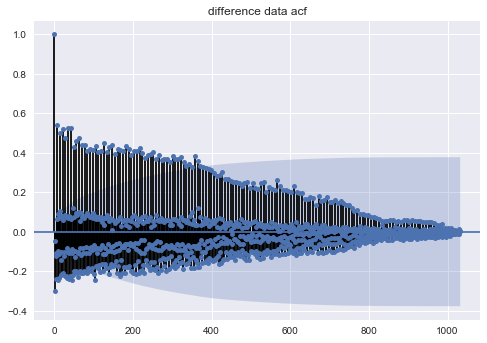

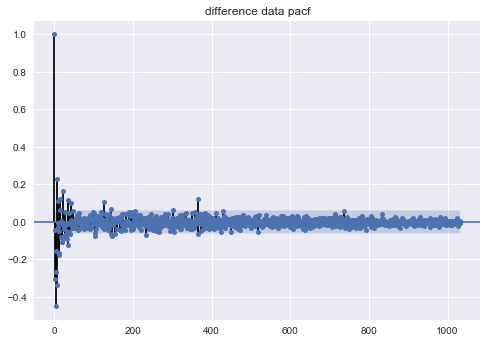

In [16]:
#decompose seasonarity
data_diff = data_log - data_log.shift()
plt.title("difference data")
plt.plot(data_diff)
plt.show()
data_diff.dropna(inplace=True)
plt.title("dfieerence data")
draw_rolling_average(data_diff)
DF_test(data_diff)

plot_acf(data_diff)
plt.title("difference data acf")
plt.show()

plot_pacf(data_diff)
plt.title("difference data pacf")
plt.show()

In [17]:
result = acorr_ljungbox(data_log, lags=1)#white nosie test

/Users/shihongliang/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


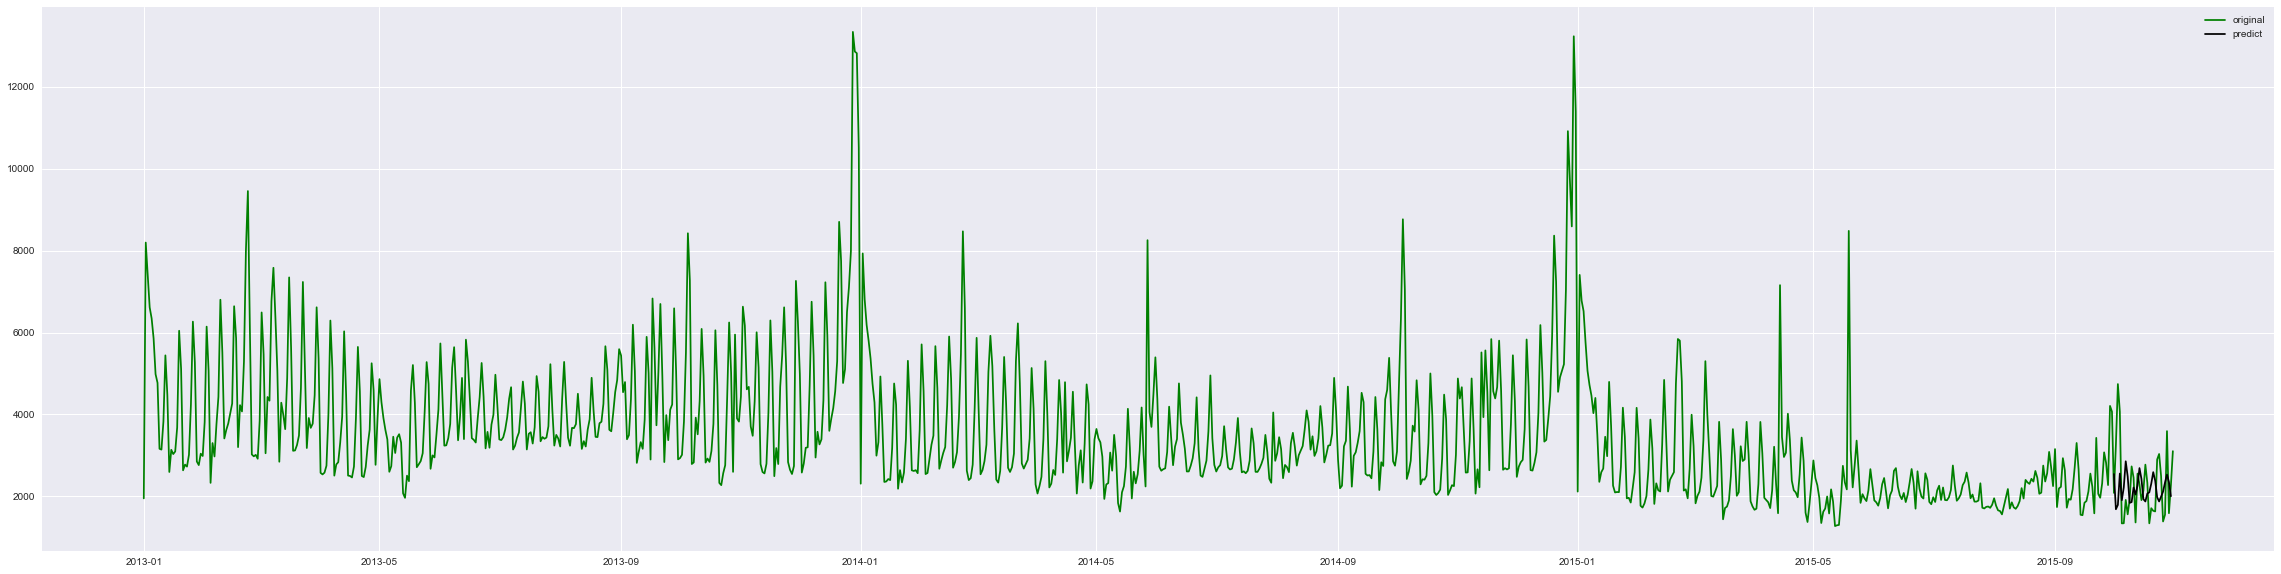

In [18]:
model = ARIMA(data_log, (9,1,2)).fit(disp=-1)#train the model for log-transformed data
res=model.forecast(30)[0]
newres=np.exp(res)
newres = pd.DataFrame(newres)
newres.index=pd.date_range('2015-10-01','2015-10-30')
Draw_pre(newres)

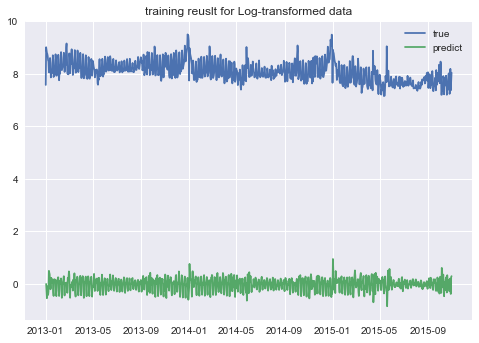

In [19]:
plt.plot(data_log,label='true')
plt.plot(model.fittedvalues, label='predict')
plt.title("training reuslt for Log-transformed data")
plt.legend()
plt.show()

In [20]:
#compute the loss
predict = model.predict()
train_MSE = ((np.exp(predict)-np.exp(data_log))**2).sum()/data.size
train_RMSE = np.sqrt(((np.exp(predict)-np.exp(data_log))**2).sum()/data.size)
train_MAE= (np.abs(np.exp(predict)-np.exp(data_log)).sum())/data.size
train_MAPE=(np.abs(np.exp(predict)-np.exp(data_log))*100/np.exp(data_log)).sum()/data.size
test_MAE = (np.abs(np.exp(predict)-np.exp(data_log))).sum()/data_log.size
test_MSE = ((np.exp(res)-np.exp(data_log['2015-10-01':'2015-10-30']))**2).sum()/data['2015-10-01':'2015-10-30'].size
test_RMSE = np.sqrt(((np.exp(res)-np.exp(data_log['2015-10-01':'2015-10-30']))**2).sum()/data['2015-10-01':'2015-10-30'].size)
test_MAE= (np.abs(np.exp(res)-np.exp(data_log['2015-10-01':'2015-10-30'])).sum())/data['2015-10-01':'2015-10-30'].size
test_MAPE=(np.abs(np.exp(res)-np.exp(data_log['2015-10-01':'2015-10-30']))*100/np.exp(data_log['2015-10-01':'2015-10-30'])).sum()/data['2015-10-01':'2015-10-30'].size

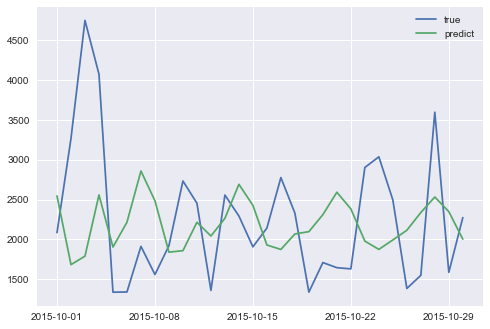

In [21]:
draw_test(np.exp(data_log),np.exp(res))#draw test result for log-transformed data

/Users/shihongliang/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


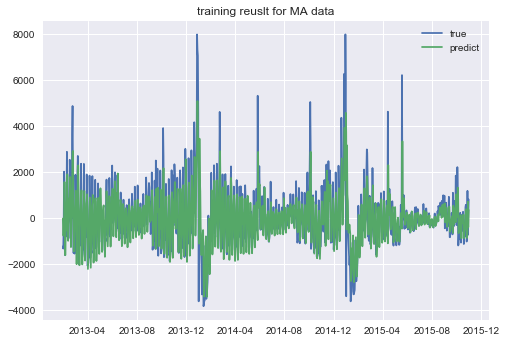

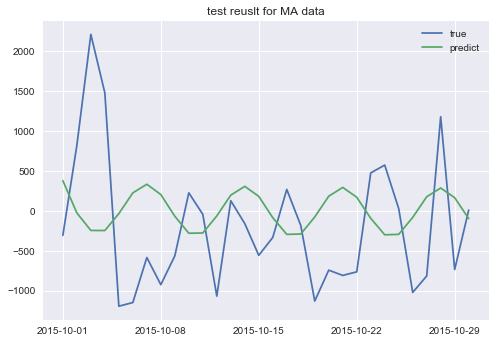

In [22]:
# train model for the Moving average
model = ARIMA(avg_diff, (3,0,4)).fit()
plt.plot(avg_diff,label='true')
plt.plot(model.fittedvalues, label='predict')
plt.title("training reuslt for MA data")
plt.legend()
plt.show()

res=model.forecast(30)[0]
plt.title("test reuslt for MA data")
draw_test(avg_diff,res)


In [23]:
#compute the loss
predict = model.predict()
#predict =np.exp(predict)
# compute the loss
MAE = (np.abs(predict-avg_diff)).sum()/data.size
train_MSE = ((predict-avg_diff)**2).sum()/data.size
train_RMSE = np.sqrt(((predict-avg_diff)**2).sum()/data.size)
train_MAE= (np.abs(predict-avg_diff)).sum()/data.size
train_MAPE=(np.abs(predict-avg_diff)*100/ewma_diff).sum()/data.size
test_MSE = ((res-avg_diff['2015-10-01':'2015-10-30'])**2).sum()/data['2015-10-01':'2015-10-30'].size
test_RMSE = np.sqrt(((res-avg_diff['2015-10-01':'2015-10-30'])**2).sum()/data['2015-10-01':'2015-10-30'].size)
test_MAE= (np.abs(res-avg_diff['2015-10-01':'2015-10-30'])).sum()/data['2015-10-01':'2015-10-30'].size
test_MAPE=(np.abs(res-avg_diff['2015-10-01':'2015-10-30'])*100/ewma_diff['2015-10-01':'2015-10-30']).sum()/data['2015-10-01':'2015-10-30'].size


/Users/shihongliang/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


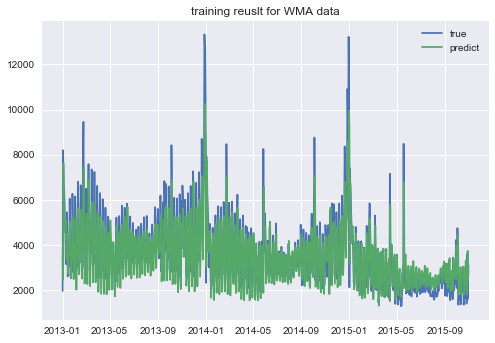

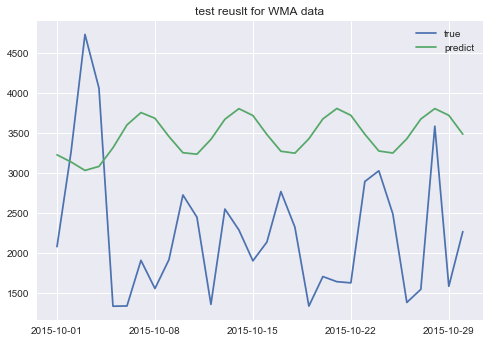

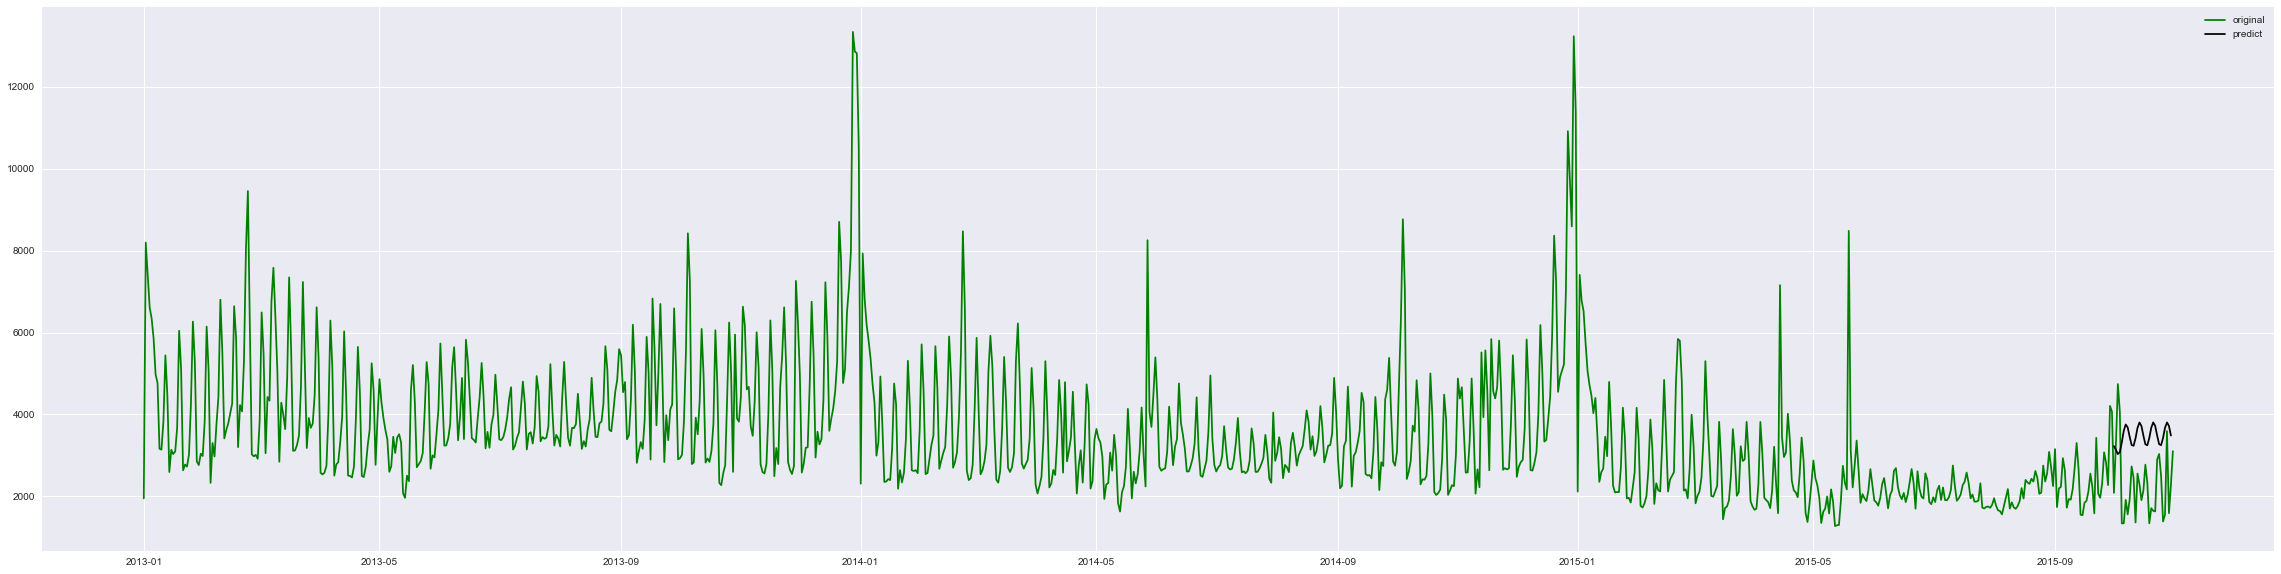

In [24]:
#test_p_q(ewma_diff)
#EWMA
ewma_diff.dropna(inplace=True)
model = ARIMA(ewma_diff,(3,0,2)).fit()
plt.plot(ewma_diff,label='true')
plt.plot(model.fittedvalues, label='predict')
plt.title("training reuslt for WMA data")
plt.legend()
plt.show()

res=model.forecast(30)[0]
plt.title("test reuslt for WMA data")
draw_test(ewma_diff,res)
res=model.forecast(30)[0]
newres=res
newres = pd.DataFrame(newres)
newres.index=pd.date_range('2015-10-01','2015-10-30')
Draw_pre(newres)

In [25]:
#compute loss
predict = model.predict()
MSE = ((predict-ewma_diff)**2).sum()/data.size
train_RMSE = np.sqrt(((predict-ewma_diff)**2).sum()/data.size)
train_MAE= (np.abs(predict-ewma_diff)).sum()/data.size
train_MAPE=(np.abs(predict-ewma_diff)*100/ewma_diff).sum()/data.size

test_MSE = ((res-ewma_diff['2015-10-01':'2015-10-30'])**2).sum()/data.size
test_RMSE = np.sqrt(((res-ewma_diff['2015-10-01':'2015-10-30'])**2).sum()/data.size)
test_MAE= (np.abs(res-ewma_diff['2015-10-01':'2015-10-30'])).sum()/data.size
test_MAPE=(np.abs(res-ewma_diff['2015-10-01':'2015-10-30'])*100/ewma_diff['2015-10-01':'2015-10-30']).sum()/data.size
